<a href="https://colab.research.google.com/github/Captmoonshot/DS-Sprint-01-Dealing-With-Data/blob/master/DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [2]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=12.053923791978267, mobile=True), User(purchased=True, time_on_site=416.4412273840208, mobile=False), User(purchased=False, time_on_site=543.5273618460775, mobile=False), User(purchased=False, time_on_site=472.6321190207721, mobile=False), User(purchased=False, time_on_site=277.23292954160024, mobile=True), User(purchased=False, time_on_site=41.27356660031631, mobile=True), User(purchased=False, time_on_site=132.4464144179392, mobile=True), User(purchased=False, time_on_site=235.37879777435032, mobile=True), User(purchased=False, time_on_site=86.61776491340459, mobile=False), User(purchased=False, time_on_site=60.608813270232154, mobile=True)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,12.053924,True
1,True,416.441227,False
2,False,543.527362,False
3,False,472.632119,False
4,False,277.232930,True


In [6]:
print(user_data.shape)

(1000, 3)


In [7]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.1365286439648,6.0412599528724416,6.382963229125193,6.554079751782327,7.4935201921816095,8.616597248001439,8.720831398190464,8.847240737761531,9.787440635645986,9.820486769989557,...,571.6546555679821,571.7047855517454,574.2196705251462,579.6058718610728,583.9671678218887,586.4901003976098,586.9025557077236,591.3720326394429,591.5388899763777,597.8781116487745
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,0,0,1,...,1,1,1,1,1,1,0,1,1,0
True,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1


In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.544, 123.685]","(123.685, 242.233]","(242.233, 360.781]","(360.781, 479.33]","(479.33, 597.878]"
purchased,,,,,
False,302,264,156,56,33
True,71,70,36,7,5


In [9]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.544, 123.685]","(123.685, 242.233]","(242.233, 360.781]","(360.781, 479.33]","(479.33, 597.878]"
purchased,,,,,
False,0.809651,0.790419,0.8125,0.888889,0.868421
True,0.190349,0.209581,0.1875,0.111111,0.131579


In [10]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.892,0.784
True,0.108,0.216


In [11]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(user_data['mobile'], time_bins, normalize='columns')

time_on_site,"(4.544, 123.685]","(123.685, 242.233]","(242.233, 360.781]","(360.781, 479.33]","(479.33, 597.878]"
mobile,,,,,
False,0.160858,0.125749,0.244792,1.0,1.0
True,0.839142,0.874251,0.755208,0.0,0.0


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [12]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [13]:
df.shape

(1200, 4)

In [14]:
df.isnull().sum()

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [15]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [16]:
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc84462ff98>,
      dtype=object)

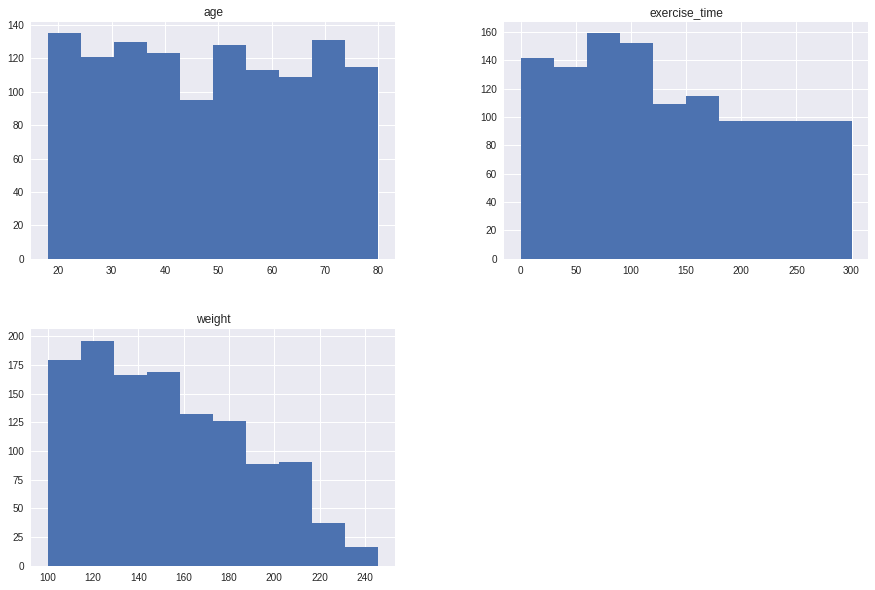

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(bins=10, figsize=(15, 10))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc841868cf8>,
      dtype=object)

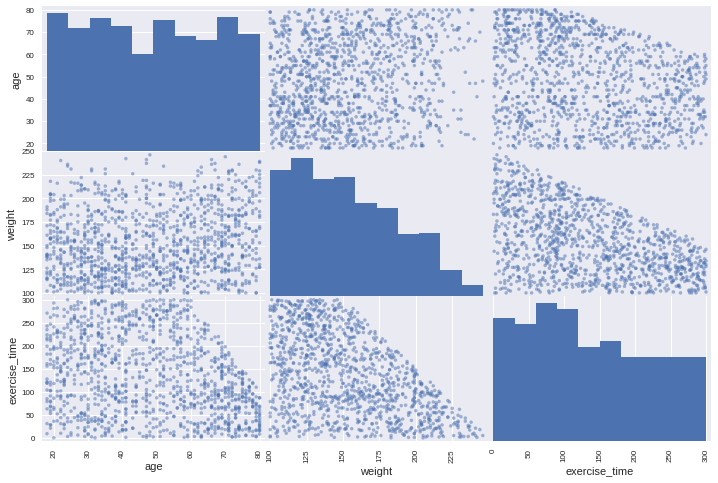

In [18]:
from pandas.tools.plotting import scatter_matrix

attributes = ['age', 'weight', 'exercise_time']

scatter_matrix(df[attributes], figsize=(12, 8))

The scatter matrix shows somewhat uniform distributions for the 'Age', and 'Exercise_Time' variables.  The 'Weight' variable is skewed to the right showing a smaller number of heavy-set people.

In [19]:
df.corr()

,age,weight,exercise_time
age,1.000000,0.144168,-0.273818
weight,0.144168,1.000000,-0.478021
exercise_time,-0.273818,-0.478021,1.000000


This is a pairwise correlation matrix between all three variables showing a somewhat weak negative relationship between weight and exercise.

There is also a very weak negative relationship between exercise and age.  


In [20]:
# Here I'm rearranging the columns of the DataFrame so I can run a Linear Regression on it by extracing
# the DataFrame values into arrays

df = df[['age', 'exercise_time', 'weight']]
df.head()

,age,exercise_time,weight
0,44,192,118
1,41,35,161
2,46,220,128
3,39,57,216
4,28,182,116


In [21]:
# Using age and exercise_time as the features, and the weight as target variable

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

features = df.loc[:, 'age':'exercise_time']
X = features.values
y = df['weight'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

LinReg = LinearRegression()
LinReg.fit(X_train, y_train)


print("Test set score: {:.2f}".format(LinReg.score(X_test, y_test)))


Test set score: 0.26


In [22]:
# Trying to see if scaling the values of the feature variables will increase the test set score

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LinReg.fit(X_train_scaled, y_train)

print("Test set score with scaled values: {:.2f}".format(LinReg.score(X_test_scaled, y_test)))

Test set score with scaled values: 0.26


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
# This time using only the exercise_time as the feature 
# Shows no difference in the test score


X = df['exercise_time'].values.reshape(-1, 1)
y = df['weight'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

LinReg2 = LinearRegression()


LinReg2.fit(X_train, y_train)

print("Test set score: {:.2f}".format(LinReg2.score(X_test, y_test)))

Test set score: 0.26


In [24]:
# Re-running previous cell so I don't have to scroll up

df.corr()

,age,exercise_time,weight
age,1.000000,-0.273818,0.144168
exercise_time,-0.273818,1.000000,-0.478021
weight,0.144168,-0.478021,1.000000


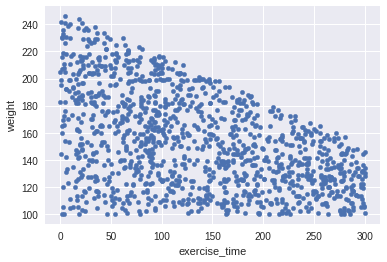

In [25]:
# Scatter plot of feature variable and target

df.plot.scatter('exercise_time', 'weight')

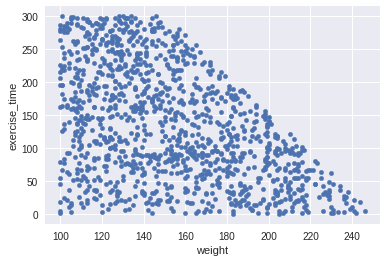

In [26]:
# Scatter plot of another feature variable and target

df.plot.scatter('weight', 'exercise_time')

In [27]:
# Maybe the relationship is such that 'age' and 'weight' affect 'exercise_time', and not the other way around
# So a possible reverse causality

# I'm going to run another LinearRegression, so I re-arrage the columns to make it easier
# to extract into array form for machine learning

df = df[['age', 'weight', 'exercise_time']]
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [28]:
# Slight improvement in score, but overall very low predictive power in terms
# of the model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

features = df.loc[:, 'age':'weight']
X = features.values
y = df['exercise_time'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

LinReg = LinearRegression()
LinReg.fit(X_train, y_train)


print("Test set score: {:.2f}".format(LinReg.score(X_test, y_test)))

Test set score: 0.29


In [0]:
exercise_bin = pd.cut(df['exercise_time'], 3)
weight_bin = pd.cut(df['weight'], 3)
age_bin = pd.cut(df['age'], 5)

In [0]:
exercise_vs_weight = pd.crosstab([exercise_bin, age_bin], weight_bin, normalize='columns' )

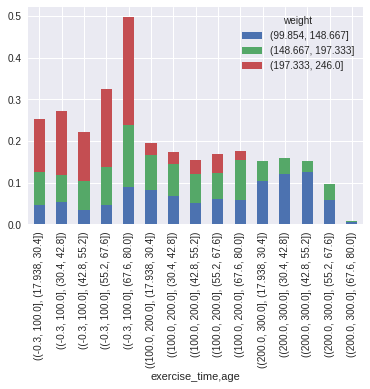

In [46]:
exercise_vs_weight.plot(kind='bar', stacked=True)

In [43]:
X = df['exercise_time']
y = df['weight']

pd.crosstab(y, age_bin, normalize='columns').head()

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
weight,,,,,
100,0.003906,0.015810,0.004484,0.022523,0.016260
101,0.011719,0.015810,0.004484,0.009009,0.000000
102,0.019531,0.007905,0.017937,0.000000,0.008130
103,0.003906,0.007905,0.008969,0.004505,0.008130
104,0.007812,0.003953,0.013453,0.000000,0.012195


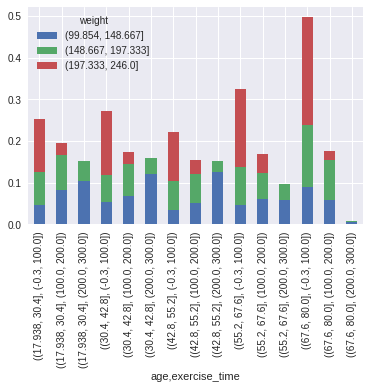

In [44]:
ct = pd.crosstab([age_bin, exercise_bin], weight_bin,
                normalize='columns')
ct.plot(kind='bar', stacked=True)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1. All the variables are continuous variables
2. There's a pretty large negative correlation (relative to other correlations in the dataset) between Excercise and Weight, and a comparatively smaller correlation between Age and Weight.  
3. It seems to me that the relationship between Excercise and Weight is spurious because they should have a positive relationship, in other words more exercise should lead to lower weight.  The real relationship seems to be between Age and Weight, since older people tend to excercise less than young people, or atleast not as intense as young people do.  


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)